## DD2424 deep19 VT19-1 Deep Learning in Data Science - Assignment 2

### Table of Content
[Exercise 1 - a](#Section_1) - Getting the data  
[View Normalized Images](#view_images) - Scroll through the images (should run cell to see widget)   
[Exercise 1 - b](#Section_2) - Parameter Initialization  
[Exercise 2 - a](#Section_3) - Evaluate Classifier/ Forward Prop  
[Exercise 2 - b](#Section_4) - Compute the cost  
[Exercise 2 - c](#Section_5) - Compute Accuracy  
[Exercise 2 - d](#Section_6) - Compute, check the gradient descent and update weights   
[Exercise 2 - e](#Section_7) - Mini Batch Gradient Descent  
[Trained Weights](#trained_weights) - Visualizing weights learnt  
[Exercise 3](#Training_Runs) - Training network with cyclical learning rates  


In [2]:
import numpy as np
import math
from PIL import Image as Img
import pickle
from scipy import misc

import sys
import os.path

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import pprint
from ipywidgets import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

np.random.seed(400)

#### Exercise 1  
<a id='Section_1'></a>

## Getting the Data

In [3]:
def LoadBatch(file):
    """
    Loads all the data from Cifar-10
    
    Argumets:
    file -- Path to main data directory
    
    Returns: 
    train_set_x, train_set_y, valid_set_x, 
    valid_set_y, test_set_x, test_set_y    -- Splits the dataset into 
    classes -- all the labels
    """
    #load data
    train_file = file + '/data_batch_1'
    valid_file = file + '/data_batch_2'
    test_file = file + '/test_batch'
    meta_file = file + '/batches.meta'

    with open(train_file, 'rb') as fo:
        train_set = pickle.load(fo, encoding='latin1')
    with open(valid_file, 'rb') as fo:
        valid_set = pickle.load(fo, encoding='latin1')
    with open(test_file, 'rb') as fo:
        test_set = pickle.load(fo, encoding='latin1')
    with open(test_file, 'rb') as fo:
        test_set = pickle.load(fo, encoding='latin1')
    with open(meta_file, 'rb') as fo:
        meta = pickle.load(fo, encoding='latin1')
    print("Load data " + u'\u2713')

    #uncomment to get data overview
    #pprint.pprint(train_set)
    #for keys,value in train_set.items():
    #    print(keys)

    # data formatting to double
    train_set_x = np.array(train_set["data"][:], dtype='d')
    train_set_y = np.array(train_set["labels"][:])
    valid_set_x = np.array(valid_set["data"][:], dtype='d')
    valid_set_y = np.array(valid_set["labels"][:])
    test_set_x = np.array(test_set["data"][:], dtype='d')
    test_set_y = np.array(test_set["labels"][:])
    classes = np.array(meta["label_names"][:])
    print("Image data to Double " + u'\u2713')

    _ = plt.rcParams['figure.figsize'] = [15, 3]
    _ = plt.subplot(131).set_title("Original")
    ax = sns.distplot(train_set_x[0, :])

    #standardising image data
    train_set_x = train_set_x / 255.
    valid_set_x = valid_set_x / 255.
    test_set_x = test_set_x / 255.
    print("Standardizing image " + u'\u2713')
    _ = plt.subplot(132).set_title("Standardized")
    ax = sns.distplot(train_set_x[0, :])

    #Normalizing image data
    #do by row as this is row and non transformed images
    #For each row i.e 1x3072
    train_mean = np.mean(train_set_x, axis=1).reshape(-1, 1)
    valid_mean = np.mean(valid_set_x, axis=1).reshape(-1, 1)
    test_mean = np.mean(test_set_x, axis=1).reshape(-1, 1)

    train_std = np.std(train_set_x, axis=1).reshape(-1, 1)
    valid_std = np.std(valid_set_x, axis=1).reshape(-1, 1)
    test_std = np.std(test_set_x, axis=1).reshape(-1, 1)

    #mean shape is 10000,1 show repeat 3072
    train_mean = np.tile(train_mean, (1, 3072))
    valid_mean = np.tile(valid_mean, (1, 3072))
    test_mean = np.tile(test_mean, (1, 3072))

    train_std = np.tile(train_std, (1, 3072))
    valid_std = np.tile(valid_std, (1, 3072))
    test_std = np.tile(test_std, (1, 3072))

    train_set_x = (train_set_x - train_mean) / train_std
    valid_set_x = (valid_set_x - valid_mean) / valid_std
    test_set_x = (test_set_x - test_mean) / test_std
    print("Normalizing image " + u'\u2713')

    _ = plt.subplot(133).set_title("Normalized")
    ax = sns.distplot(train_set_x[0, :])

    #one-hot encoding labels
    n_values = len(classes)
    train_set_y = np.eye(n_values)[train_set_y]
    valid_set_y = np.eye(n_values)[valid_set_y]
    test_set_y = np.eye(n_values)[test_set_y]
    print('one hot encoding ' + u'\u2713')

    _ = plt.show(ax)

    return train_set_x, train_set_y, valid_set_x, valid_set_y, test_set_x, test_set_y, classes

Load data ✓
Image data to Double ✓


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Standardizing image ✓
Normalizing image ✓
one hot encoding ✓


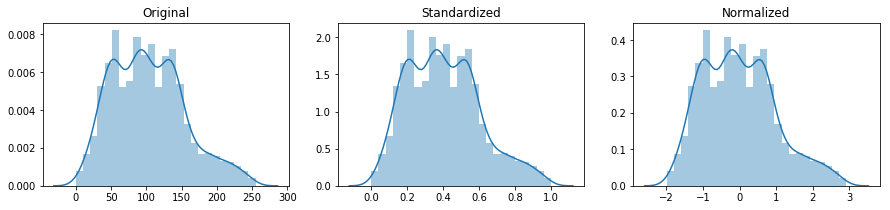

Reshaping ✓
Mean 0 and Std. 1✓


In [4]:
#get the data
train_set_x, train_set_y, valid_set_x, valid_set_y, test_set_x, test_set_y, classes = \
                                LoadBatch(os.path.join(os.getcwd(), "..", 'cifar-10'))

#reshaping labels
train_x = train_set_x.transpose()
valid_x = valid_set_x.transpose()
test_x  = test_set_x.transpose()
train_y = train_set_y.transpose()
valid_y = valid_set_y.transpose()
test_y  = test_set_y.transpose()
print("Reshaping " +u'\u2713' )

if np.unique(np.round(np.mean(train_set_x, axis = 1).reshape(-1,1)))[0] == 0: 
    if np.unique(np.round(np.std(train_set_x, axis = 1).reshape(-1,1)))[0] == 1:
        print("Mean 0 and Std. 1" +u'\u2713' )

## Sneak peak  into the dataset 

In [5]:
num_train = train_x.shape[1]
num_valid = valid_x.shape[1]
num_test = test_x.shape[1]
num_px = train_x.shape[0]


print ("Number of training examples: " + str(num_train))
print ("Number of valid examples: " + str(num_valid))
print ("Number of testing examples: " + str(num_test))
print ("Each image is of size: "+str(num_px))
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("valid_x shape: " + str(valid_x.shape))
print ("valid_y shape: " + str(valid_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))
print ("classes shape :" + str(classes.shape))

Number of training examples: 10000
Number of valid examples: 10000
Number of testing examples: 10000
Each image is of size: 3072
train_x shape: (3072, 10000)
train_y shape: (10, 10000)
valid_x shape: (3072, 10000)
valid_y shape: (10, 10000)
test_x shape: (3072, 10000)
test_y shape: (10, 10000)
classes shape :(10,)


## Check out some pics
<a id='view_images'></a>

In [6]:
def show_image(index):
    """
    Displays images from train_set_x i.e the raw set without dimetionality change
    
    Arguments -- index of the image from 1-10,000
    
    Returns -- None, Use slider to view all images
    """
    #for train_set_x
    sample = train_set_x[index]
    sample = sample*255.
    R = sample[0:1024].reshape(32,32)    
    G = sample[1024:2048].reshape(32,32)    
    B = sample[2048:].reshape(32,32)    
    img = np.dstack((R,G,B))
    img = Img.fromarray(img.astype("uint8"))
    plt.imshow(img,interpolation='bicubic')
    label = np.where(train_y[:,index]==1)
    plt.title(classes[label][0])

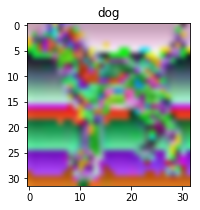

In [7]:
ax = show_image(9999)

In [8]:
_ = interact(show_image,index = widgets.IntSlider(min = 0, max = 9999, step = 1, value=9999))

interactive(children=(IntSlider(value=9999, description='index', max=9999), Output()), _dom_classes=('widget-i…

#### Exercise 1 - b
<a id='Section_2'></a>

## Paramater Initialization

In [9]:
def initialize_parameters(N, d, layers, m):
    """
    Initialize all the params need for the neural network
    
    Arguments:
    layers -- number of layers for the NN (here 1)
    N -- number of images NN is trained on
    d -- dimensions of input imagetaken from each sample, 
         could vary to check the gradients faster
    m -- number of neurons in hidden layer
    
    Returns:
    X -- Input to NN
    Y -- Ground Truth
    parameters -- NN parameters Ws and b(s)
    GDparams -- parameters to control the Gradient descent
    lambd -- regularization co-eff
    """
    
    #Number of possible predictions
    K = len(classes)
    #Subset of data to be trained on
    X = train_x[:,:N]
    Y = train_y[:,:N]
    #Gausssian parameters for W, b
    mu = 0
    sigma1 = 1/math.sqrt(d)
    sigma2 = 1/math.sqrt(m)
    parameters = {}
    L = layers           # number of layers in the network

    parameters['W1'] = np.random.normal(loc = mu, scale = locals()["sigma1"], size = (m,d)) 
    parameters['b1'] = np.random.normal(loc = mu, scale = locals()["sigma1"], size = (m,1)) 
    #parameters['b1'] = np.zeros((m,1))
    parameters['W2'] = np.random.normal(loc = mu, scale = locals()["sigma2"], size = (K,m)) 
    parameters['b2'] = np.random.normal(loc = mu, scale = locals()["sigma2"], size = (K,1)) 
    #parameters['b2'] = np.zeros((K,1))

    #regularization co-eff
    lambd = 0
    #n_batch=batch_size NOT the number of batches
    GDparams = {}
    GDparams['n_batch'] = 100
    GDparams['eta'] = 0.001
    GDparams['n_epochs'] = 200

    #Get the shapes right
    assert(X.shape == (d, N))
    assert(Y.shape == (K, N))
    assert(classes.size == 10)
    
    return X, Y, parameters, GDparams, lambd

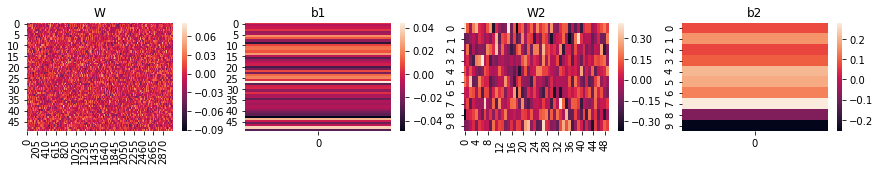

In [10]:
#Constants
N = 11
d = num_px
K = len(classes)
layers = 2
m = 50
X, Y, parameters, GDparams, lambd = initialize_parameters(N, d, layers, m)
_ = plt.rcParams['figure.figsize'] = [15, 2]
_ = plt.subplot(141).set_title("W")
ax = sns.heatmap(parameters['W1'])
_ = plt.subplot(142).set_title("b1")
ax = sns.heatmap(parameters['b1'])
_ = plt.subplot(143).set_title("W2")
ax = sns.heatmap(parameters['W2'])
_ = plt.subplot(144).set_title("b2")
ax = sns.heatmap(parameters['b2'])

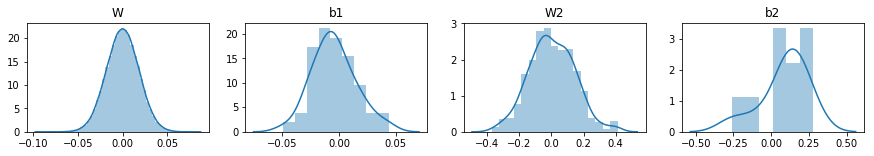

In [11]:
_ = plt.rcParams['figure.figsize'] = [15, 2]
_ = plt.subplot(141).set_title("W")
ax = sns.distplot(parameters['W1'].reshape(-1,1))
_ = plt.subplot(142).set_title("b1")
ax = sns.distplot(parameters['b1'].reshape(-1,1))
_ = plt.subplot(143).set_title("W2")
ax = sns.distplot(parameters['W2'].reshape(-1,1))
_ = plt.subplot(144).set_title("b2")
ax = sns.distplot(parameters['b2'].reshape(-1,1))

####    Exercise 2 - a
<a id='Section_3'></a>


## Forward Propogation

In [12]:
def softmax(x):
    """
    Instead of using np.exp(x)/np.sum(np.exp(x))
    I decrease the value of x with the max, 
    it could be any number as it cancels out when equation is expanded
    This is to avoid overflow due to exponential increase
    
    Argumets:
    x -- Product W, X
    
    Returns:
    soft -- softmax(W,X)
    """
    e_x = np.exp(x - np.max(x, axis = 0))
    soft = e_x / np.sum(e_x, axis = 0)
    return soft

def ReLU(s):
    """
    ReLU activation function
    
    Arguments:
    s -- Classifier output i.e W*X + b
    
    Returns:
    array replacing negative values with 0
    """
    return np.where(s < 0, 0, s)

def EvaluateClassifier(X, parameters):
    """
    s1 = W1x + b1 
    h = max(0, s1)
    s = W2h + b2
    p = SOFTMAX(s) 
    
    Arguments:
    X -- Input data
    W -- Weights
    b -- bias
    
    Returns:
    P -- Probabilities of each class for each sample in X
    """
    s1 = np.dot(parameters["W1"], X) + parameters["b1"]
    #possible error
    H = ReLU(s1)
    s = np.dot(parameters["W2"], H) + parameters["b2"]
    P = softmax(s)
    
    #Dimensional check -- removed as it conflicts with minibatches
    #assert(X.shape == (d,N)),X.shape
    #assert(P.shape == (K,N))
    return H, P

In [13]:
H, P = EvaluateClassifier(X, parameters)

In [14]:
def visulaize_predictions(P, Y):
    """
    Just an excuse to use the beautiful seaborn :)
    
    Arguments:
    P -- Probabilties to get the predicitons
    Y -- Ground truth
    
    Returns:
    None -- Nice plots
    """
    
    plt.rcParams['figure.figsize'] = [25, 5]
    plt.subplot(141).set_title("Prediction")
    predictions = (P == P.max(axis = 0,keepdims = 1)).astype(float)
    ax = sns.heatmap(predictions)
    plt.subplot(142).set_title("Ground Truth")
    ax = sns.heatmap(Y)
    plt.subplot(143).set_title("Correct Matches")
    matches = (np.multiply(Y,predictions)).astype(float)
    ax = sns.heatmap(matches)
    plt.subplot(144).set_title("Differences")
    matches = Y + predictions
    ax = sns.heatmap(matches)
    plt.show(ax)

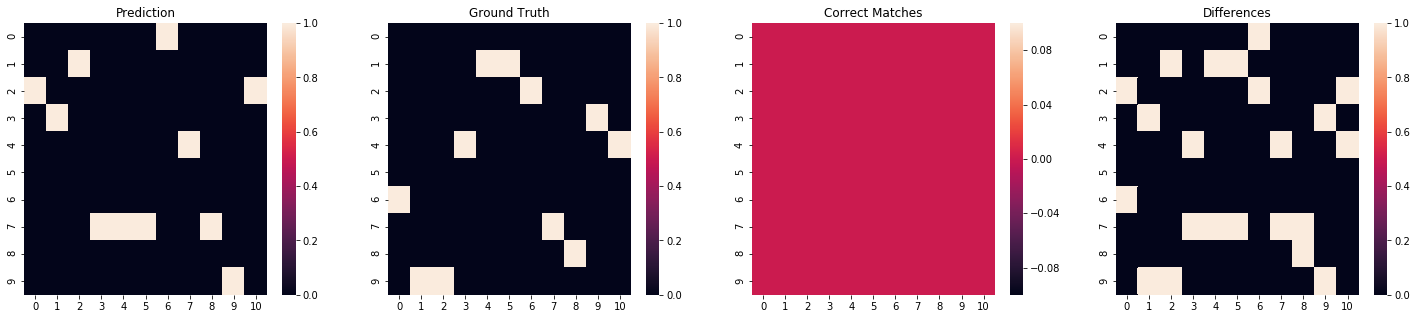

In [15]:
visulaize_predictions(P,Y)

#### Exercise 2 - b
<a id='Section_4'></a>

## Computing the cost

In [16]:
def ComputeCost_CrossEntropy(P, Y, parameters):
    """
    Loss of current state of prediction w.r.t the ground truth
    
    Arguments:
    P -- Probabilities of each class of each sample in input data
    Y -- Ground truth
    W -- Weights that produced the probabilities (Can be used in num. GD as well)

    Returns:
    cost -- sum of crossentropy loss and regularization term
    """
    
    P = np.reshape(P, (K, -1))
    ground_truth = np.reshape(Y, (K, -1))
    product = np.multiply(Y, P).sum(axis = 0)
    
    #cross entropy loss - Handling -log0 tending to infinity
    product[product == 0] = np.finfo(float).eps    #very low value
    crossEntropyLoss = np.mean(-np.log(product)) #.sum() / N

    
    L2_regularization_cost = lambd * (np.power(parameters["W1"], 2).sum()+ \
                                      np.power(parameters["W2"], 2).sum())
    
    cost = crossEntropyLoss + L2_regularization_cost
    return  cost

In [17]:
cost = ComputeCost_CrossEntropy(P, Y, parameters)
print(cost)

2.3610836445726626


#### Exercise 2 - c
<a id='Section_5'></a>

## Accuracy of the predictions

In [18]:
def ComputeAccuracy(P, Y):
    """
    instead of using function acc = ComputeAccuracy(X, y, W, b)
    and calculating P again lets use it from the from the prev. output
    
    Arguments:
    P -- Probabilities of each class
    Y -- Ground Truth
    
    Returns:
    Accuracy -- Number of matches btw ground truth and predicions from probabilities
    """
    predictions = np.argmax(P,axis=0)
    groundtruth = np.argmax(Y,axis=0)
    matches = np.sum(predictions == groundtruth)
    total = len(predictions)
    accuracy = (matches/float(total))
    assert(P.shape == Y.shape)
    return accuracy

In [19]:
accuracy = ComputeAccuracy(P, Y)
print ("Accuracy :" +  str(accuracy))

Accuracy :0.0


#### Exercise 2 - d
<a id='Section_6'></a>

## Computing the Gradients

In [20]:
def ComputeGradients(X, Y, P, H, parameters, lambd):
    """ 
    G -- dJ/dZ - g for Batch
    Z -- WX
    grad_W1 -- dJ/dW
    grad_b -- dJ/db
    grad_L -- dJ/dL Regularization term
    grad_W -- dJ/dW + Regularization term

    Argumets:
    X -- input data
    Y -- Ground truth
    P -- current probabilities/ Output Layer's output
    H -- Activation output/ Hidden Layer's output
    W -- Current weights that generated the probabilities
    b -- current bias
    lambd -- lambda - Regularization term (to differ from the keyword itself)
    
    Returns:
    cache -- gradiants of all parameters    
    """
    
    cache = {}
    
    cache["grad_W1"] = np.zeros_like(parameters["W1"])
    cache["grad_b1"] = np.zeros_like(parameters["b1"])
    cache["grad_W2"] = np.zeros_like(parameters["W2"])
    cache["grad_b2"] = np.zeros_like(parameters["b2"])
    
    N = X.shape[1]

    for i in range(N):
        x = X[:,i].reshape(-1,1)
        y = Y[:,i].reshape(-1,1)
        p = P[:,i].reshape(-1,1)
        h = H[:,i].reshape(-1,1)
        g = -(y - p)
        
        cache["grad_b2"] += g
        cache["grad_W2"] += np.outer(g,h)    # or simply (g.dot(x.T)
        
        g = np.dot(parameters["W2"].T, g)
        positiveActivation = np.where(h > 0, 1, 0)
        g = g * positiveActivation
        
        cache["grad_b1"] += g
        cache["grad_W1"] += np.outer(g,x)    # or simply (g.dot(x.T)
        
        
    cache["grad_W2"] /= N
    cache["grad_b2"] /= N
    cache["grad_W2"] += 2 * lambd * parameters["W2"]    #Regularization term
    
    cache["grad_W1"] /= N
    cache["grad_b1"] /= N
    cache["grad_W1"] += 2 * lambd * parameters["W1"]    #Regularization term
    
#     assert(cache["grad_W1"].shape == (m, d))
#     assert(cache["grad_b1"].shape == (m, 1))
#     assert(cache["grad_W2"].shape == (K, m))
#     assert(cache["grad_b2"].shape == (K, 1))
           
    return cache

In [21]:
cache = ComputeGradients(X, Y, P, H, parameters, lambd)
print (np.unique(cache["grad_W1"]))    #just to check if its not null
print (np.unique(cache["grad_b1"]))

[-0.24253062 -0.23868832 -0.22015285 ...  0.14253809  0.14338015
  0.14409422]
[-0.06202737 -0.06126858 -0.05774344 -0.05463415 -0.03064663 -0.02859116
 -0.02519478 -0.02108286 -0.01799573 -0.01505543 -0.01497775 -0.0117284
 -0.00985427 -0.00353467 -0.00322094 -0.00257348 -0.00248349  0.00017032
  0.00081753  0.00392465  0.00497528  0.00646388  0.00664502  0.0073514
  0.01015809  0.0103657   0.01122549  0.01229376  0.01260177  0.01270762
  0.01389747  0.01486226  0.01567311  0.01635888  0.01679781  0.01751545
  0.0206493   0.02242623  0.02719144  0.02794263  0.03355863  0.03416259
  0.0352916   0.03536675  0.03555297  0.03680853  0.03792427  0.03879312
  0.04497546  0.0660759 ]


## Gradient Checking

In [21]:
def compute_grads_num(X, Y, parameters):
    """
    Numerical gradient descent using finite difference method. 
    
    Arguments:
    X -- Input dataset/ subset
    Y -- Corresponding Ground Truth
    parameters -- For all layers
        W -- Current Weights
        b -- current bias

    Returns:
    cache -- For all layers
        grad_W -- Numerical Gradient of W  
        grad_b -- Numerical Gradient of b
    """
    N = X.shape[0]
    cache = {}
    cache["grad_W1"] = np.zeros_like(parameters["W1"])
    cache["grad_b1"] = np.zeros_like(parameters["b1"])
    cache["grad_W2"] = np.zeros_like(parameters["W2"])
    cache["grad_b2"] = np.zeros_like(parameters["b2"])
    
    h = 1e-7    #very small number by which you want to vary the params
    H, P = EvaluateClassifier(X, parameters)
    c = ComputeCost_CrossEntropy(P, Y, parameters)
    
    
    for l in range(1, layers+1):
        for i in tqdm(range(parameters["W" + str(l)].shape[0]), desc = "Weights"):
            for j in range(parameters["W" + str(l)].shape[1]):
                parameters["W" + str(l)][i, j] += h    #change the weights and see if the cost reduces!
                H, P = EvaluateClassifier(X, parameters) #!!!!As ComputeCost_CrossEntropy takes P directly, update it
                c2 = ComputeCost_CrossEntropy(P, Y, parameters);
                parameters["W" + str(l)][i, j] -= h
                cache["grad_W" + str(l)][i, j] = (c2-c) / h; #if cost decreases, value negative,
                                           #hence add this grad to W, ViceVersa
    for l in range(1, layers+1):
        for i in tqdm(range(parameters["b" + str(l)].shape[0]), desc = "Bias"):
            parameters["b" + str(l)][i] += h;    #change the bias and see if the cost reduces!
            H, P = EvaluateClassifier(X, parameters) #!!!!As ComputeCost_CrossEntropy takes P directly, update it
            c2 = ComputeCost_CrossEntropy(P, Y, parameters);
            parameters["b" + str(l)][i] -= h;
            cache["grad_b" + str(l)][i] = (c2-c) / h;
    
    return cache

In [38]:
cacheNum = compute_grads_num(X, Y, parameters)
print(np.unique(cacheNum["grad_W2"]))    #Sanity check -- just to know they are not all 0's
#print(np.unique(cacheNum["grad_b2"]))

[-0.29586014 -0.28710094 -0.22236792 -0.18642197 -0.17472179 -0.16899441
 -0.16267423 -0.16193964 -0.16188104 -0.15670531 -0.14829633 -0.14566415
 -0.14505514 -0.13732695 -0.13464867 -0.13343426 -0.13314748 -0.13094875
 -0.12769855 -0.12734835 -0.12476637 -0.11871566 -0.1127682  -0.11183909
 -0.11106641 -0.10657664 -0.10641712 -0.1052248  -0.10517038 -0.10486268
 -0.102646   -0.09994585 -0.09842826 -0.09831936 -0.09765339 -0.09745861
 -0.09653241 -0.09600092 -0.09567835 -0.09428037 -0.09213489 -0.08983737
 -0.08978207 -0.08958939 -0.08818718 -0.08814383 -0.08782369 -0.08540253
 -0.08527487 -0.0848534  -0.08413879 -0.08337095 -0.08225296 -0.08127209
 -0.08071904 -0.08052027 -0.07872161 -0.07851046 -0.07403797 -0.07373355
 -0.07294063 -0.07131666 -0.07099025 -0.06916662 -0.06833306 -0.06731238
 -0.06638202 -0.06397282 -0.06285332 -0.05779936 -0.05779821 -0.05733042
 -0.05541989 -0.05500106 -0.05396344 -0.05202788 -0.05131126 -0.0503712
 -0.04968792 -0.04913639 -0.04882934 -0.04860225 -0.

In [22]:
def gradient_check(cache, cacheNum, epsilon):
    """
    Calculating realtive error between analytically and numerically computed gradient
    and checking if they are small. (smaller than epsilon)
    
    Order of the gradients does not matter
    
    Arguments:
    cache -- Analytical gradient
    cacheNum -- Numerical gradient
    epsilon -- very small value by which gradNum and gradAnly could differ
    
    Returns:
    None -- Prints relative error of gradAnly and gradNum
    """
    for l in range(1, layers+1):
        #Weights
        grad1 = cache["grad_W" + str(l)]
        grad2 = cacheNum["grad_W" + str(l)]
        difference = np.linalg.norm(grad1 - grad2)  #Could simply use np.abs(grad1 - grad2).sum()      
        summation = np.linalg.norm(grad1) + np.linalg.norm(grad2)  #varitaion - 2.0988034043225143e-08 only
        denominator = max(epsilon, summation)    #to avoid division by 0
        relative_error = difference / denominator                                                     

        if relative_error < 1e-6:
            print(u'\u2714  ' + "The gradient for W" + str(l) +" is correct! " + 
                  str(relative_error))
        else:
            print("Relative_error for grad_W" + str(l) + " :" + str(relative_error))
            print(u'\u2718  ' + "The gradient is wrong!")

    for l in range(1, layers+1):
        #bias
        grad1 = cache["grad_b" + str(l)]
        grad2 = cacheNum["grad_b" + str(l)]
        difference = np.linalg.norm(grad1 - grad2)  #Could simply use np.abs(grad1 - grad2).sum()      
        summation = np.linalg.norm(grad1) + np.linalg.norm(grad2)  #varitaion - 2.0988034043225143e-08 only
        denominator = max(epsilon, summation)    #to avoid division by 0
        relative_error = difference / denominator                                                     

        if relative_error < 1e-6:
            print(u'\u2714  ' + "The gradient for b" + str(l) + " is correct! "+ 
                  str(relative_error))
        else:
            print("Relative_error for grad_b" + str(l) + " :" + str(relative_error))
            print(u'\u2718  ' + "The gradient is wrong!")
#    return relative_error

In [40]:
gradient_check(cache, cacheNum, 1e-6)   #check all gradients

✔  The gradient for W1 is correct! 3.960852463282282e-08
✔  The gradient for W2 is correct! 2.5458927410215876e-08
✔  The gradient for b1 is correct! 3.5872226722063074e-08
✔  The gradient for b2 is correct! 3.003918633223974e-08


In [23]:
def update_params(parameters, cache, eta):
    """
    Updating Weights and bias with the calculated gradients
    
    Arguments:
    parameters -- For all layers
        W -- prev. Weights
        b -- prev. bias
    eta -- learning rate
    
    Returns:
    parameters -- For all layers
        W -- updated Weights
        b -- updated bias
    """
    
    for l in range(1, layers+1):
        parameters["W"+str(l)] = parameters["W"+str(l)] - eta*cache["grad_W"+str(l)]
        parameters["b"+str(l)] = parameters["b"+str(l)] - eta*cache["grad_b"+str(l)]
        
    return parameters 

In [42]:
parameters = update_params(parameters, cache, GDparams['eta'])
print(np.unique(parameters["W1"])) #just to check the variation
# print(np.unique(parameters["b1"]))
# print(np.unique(parameters["W2"]))
# print(np.unique(parameters["b2"]))

[-0.09258072 -0.09227222 -0.08172507 ...  0.07446401  0.08022069
  0.08224953]


#### Exercise 2 - e
<a id='Section_7'></a>
## Mini Batch Gradient Descent

In [24]:
def get_mini_batches(X, Y, n_batch): 
    """
    Convert the whole dataset into smaller chunks
    
    Arguments:
    X -- Total input data
    Y -- Corresponding ground truth
    n_batch -- Number of samples in each batch (different from number of batches)
    
    Returns:
    mini_batches -- collection of small datasets each of size atmost n_batch
    """
    
    mini_batches = []
    X = X.T
    Y = Y.T
    data = np.hstack((X, Y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // n_batch 
    i = 0

    for i in range(n_minibatches): #as n_minibatch is floor of data.shape[0]/n_batch
        mini_batch = data[i * n_batch:(i + 1)*n_batch, :] 
        X_mini = mini_batch[:, :-10]
        Y_mini = mini_batch[:, 3072:]     #if needed .reshape((mini_batch[0].shape,10))
        mini_batches.append((X_mini, Y_mini)) 

    if data.shape[0] % n_batch != 0: 
        mini_batch = data[(i + 1)*n_batch:data.shape[0],:]
        X_mini = mini_batch[:, :-10] 
        Y_mini = mini_batch[:, 3072:]     #if needed .reshape((mini_batch[0].shape,10))
        mini_batches.append((X_mini, Y_mini)) 

    import math
    assert(len(mini_batches) == math.ceil(float(X.shape[0])/n_batch))
    return mini_batches  

In [25]:
mini_batches = get_mini_batches(X, Y, GDparams['n_batch'])
print("Number of batches :", len(mini_batches))

Number of batches : 1


In [151]:
def MiniBatchGD(X,
                Y,
                X_val,
                Y_val,
                GDparams,
                parameters,
                lambd,
                cyclic_params={}):
    """
    Perform Minibatch gradient descent shuffling at each iteration
    
    Argumets:
    X -- Total train data
    Y -- corresponding Ground truth
    X_val -- Total validation data
    Y_val -- corresponding Ground truth
    GDparams -- batch size, number of epochs, learning rates
    parameters -- For all layers
        W -- initial Weights
        b -- initial Bias

    Returns:
    parameters -- For all layers
        W -- trained Weights
        b -- trained bias
    """

    #Set up the canvas to do live plotting of the training info
    log = {
        "training loss": [],
        "validation loss": [],
        "training acc": [],
        "validation acc": []
    }  #using terms cost and loss interchangably
    fig = plt.figure(figsize=(8, 3))  #must include %matplotlib notebook
    Loss = fig.add_subplot(121)
    Accuracy = fig.add_subplot(122)

    #plt.ion() #iteractive mode on
    plt.subplot(121).set_title("Loss")
    plt.xlabel('Epoches', axes=Loss)
    plt.ylabel('Loss', axes=Loss)
    plt.subplot(122).set_title("Accuracy")
    plt.xlabel('Epoches', axes=Accuracy)
    plt.ylabel('Accuracy', axes=Accuracy)
    fig.show()
    fig.canvas.draw()

    step = 0  #to display each step accuracy if needed
    l = 0  #to keep track of the cyclic learning rate
    for i in tqdm(range((GDparams['n_epochs']))):  #progress bar

        mini_batches = get_mini_batches(
            X, Y, GDparams['n_batch'])  #shuffled every iteration
        for batch in mini_batches:
            #do transpose again as we did earlier in mini_batch to stack'em up
            X_b = batch[0].T
            Y_b = batch[1].T
            H, P = EvaluateClassifier(
                X_b, parameters)  # Get some predictions of the minibatch
            #no need to calculate for each mini batch
            cost = ComputeCost_CrossEntropy(
                P, Y_b, parameters)  # Get the cost of these predictions
            acc = ComputeAccuracy(P, Y_b)  # Get accuracy of predictions
            cache = ComputeGradients(X_b, Y_b, P, H, parameters,
                                     lambd)  # Learn the mini batch
            if len(cyclic_params) is not 0:
                cyclic_params = cycle_eta(t=step,
                                          l=l,
                                          cyclic_params=cyclic_params)
                eta = cyclic_params['eta']
                #if current is 2ns then next i.e 2ns+1 is in next cycle
                if step > 2 * cyclic_params['ns'] and \
                   step %  2 * cyclic_params['ns'] is 0:
                    l += 1
                    
                if(l==1):
                    print("One Cycle")
                    return
            else:
                eta = GDparams['eta']
            parameters = update_params(parameters, cache,
                                       eta)  # Tune the weights and bias
            #print('Step ' + str(step) + ": Cost:" + str(cost) + " Accuracy: " + str(acc))
            step += 1

        #check performance of new W, b on training data
        H, P_train = EvaluateClassifier(X, parameters)
        log["training loss"].append(
            ComputeCost_CrossEntropy(P_train, Y, parameters))
        log["training acc"].append(ComputeAccuracy(P_train, Y))

        #check performance of new W, b on validation data
        H, P_val = EvaluateClassifier(X_val, parameters)
        log["validation loss"].append(
            ComputeCost_CrossEntropy(P_val, Y_val, parameters))
        log["validation acc"].append(ComputeAccuracy(P_val, Y_val))

        #display the log
        #sns.set() #seaborn for beautiful plots
        #Loss.clear() #clear last epoch's plot
        #Accuracy.clear()
        Loss.plot(log["training loss"], 'c', label="training")
        Loss.plot(log["validation loss"], 'm', label="validation")
        Accuracy.plot(log["training acc"], 'c', label="training")
        Accuracy.plot(log["validation acc"], 'm', label="validation")
        if (i == 0):  #cant get it to work anyother way
            Loss.legend()
            Accuracy.legend()
        fig.canvas.draw()  # draw

    return parameters

## Testing Mini-Batch results

<IPython.core.display.Javascript object>


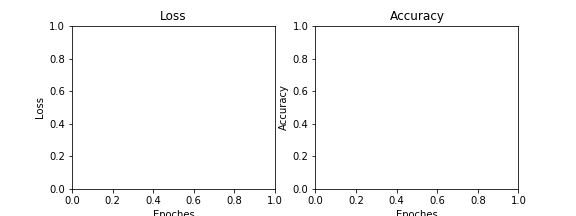

KeyboardInterrupt: 

In [152]:
%matplotlib notebook
#Constants
N = 10000
d = num_px
K = len(classes)
layers = 2
m = 50
X, Y, parameters, GDparams, lambd = initialize_parameters(N, d, layers, m)
#Overriding the GDparams
GDparams = {}
GDparams['n_batch'] = 100
GDparams['eta'] = 0.1
GDparams['n_epochs'] = 2
lambd = 0
trained_parameters = MiniBatchGD(X, Y, valid_x, valid_y, GDparams, parameters, lambd)

In [139]:
H, P_test = EvaluateClassifier(test_x, trained_parameters)
print("Loss on the test dataset :",
      ComputeCost_CrossEntropy(P_test, test_y, trained_parameters))
print("Accuracy on the test datset :", ComputeAccuracy(P_test, test_y))

Loss on the test dataset : 1.7558600974691063
Accuracy on the test datset : 0.3833


### To visualize False Positives and True Negatives
<a id='bestPredictions'></a>

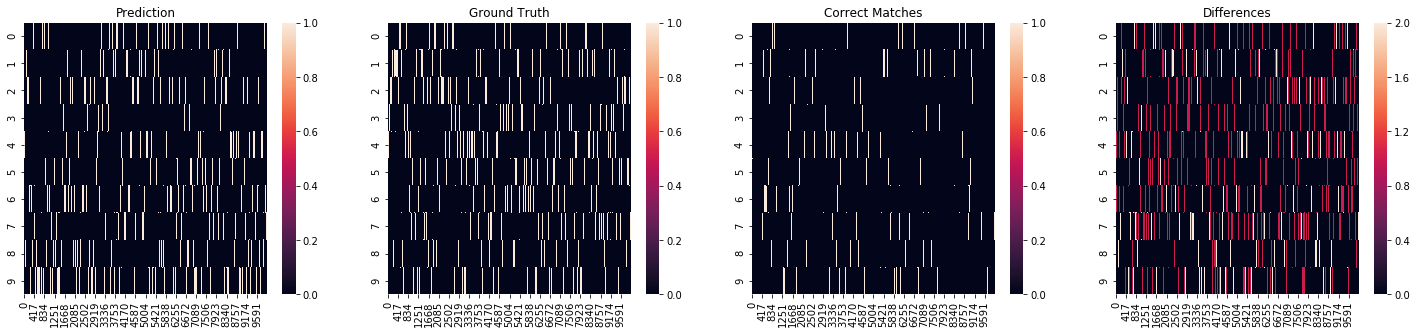

In [128]:
%matplotlib inline
visulaize_predictions(P_test,test_y)

 ## Exercise 3
 <a id='Training_Runs'></a>

 ### Train your network with cyclical learning rates

In [129]:
def cycle_eta(t, l, cyclic_params):
    """
    Function to provide cyclic learning rates
    
    Arguments:
    t -- Current step count (at time t)
    l -- Current cycle count
    cyclic_params -- Dictionary to keep track of eta curr/min/max and step-size
    ns -- stepsize of the cycle (ns = k * lowerbound(n/nbatch))
          (not to be confused with the training step size)
    """
    if (2 * l * cyclic_params['ns'] <= t <= (2 * l + 1) * cyclic_params['ns']):

        cyclic_params['eta'] = cyclic_params['eta_min'] + \
                               ((t - 2 * l * cyclic_params['ns']) / cyclic_params['ns']) * \
                               (cyclic_params['eta_max'] - cyclic_params['eta_min'])

    elif ((2 * l + 1) * cyclic_params['ns'] <= t <= 2 *
          (l + 1) * cyclic_params['ns']):


        cyclic_params['eta'] = cyclic_params['eta_max'] - \
                               ((t - (2 * l + 1) * cyclic_params['ns']) / cyclic_params['ns']) * \
                               (cyclic_params['eta_max'] - cyclic_params['eta_min'])
    return cyclic_params

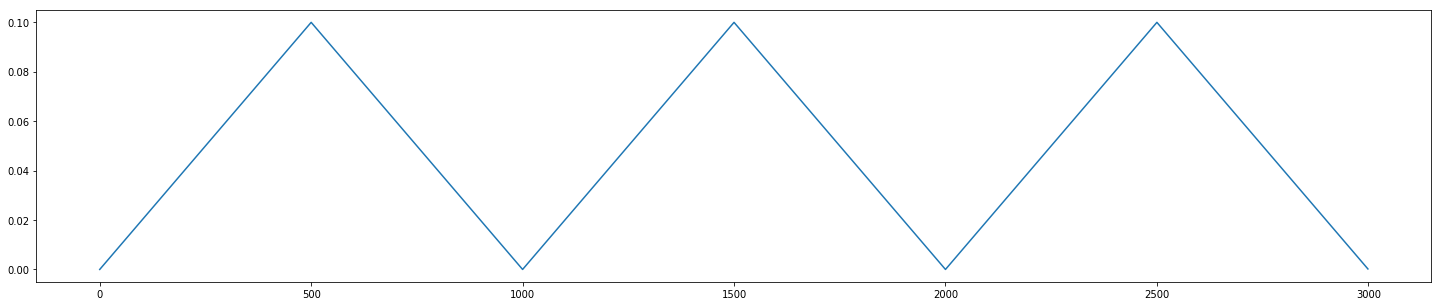

In [132]:
cyclic_params = {}
cyclic_params['eta_max'] = 1e-1
cyclic_params['eta_min'] = 1e-5
cyclic_params['eta'] = 1e-5
cyclic_params['ns'] = 500 #ns = k * lowerbound(n/nbatch)
log = []
t = 0
for l in range(3):
    for i in range(cyclic_params['ns']):
        cyclic_params = cycle_eta(t, l, cyclic_params)
        log.append(cyclic_params['eta'])
        t += 1
    for i in range(cyclic_params['ns']):
        cyclic_params = cycle_eta(t, l, cyclic_params)
        log.append(cyclic_params['eta'])
        t += 1
_ = plt.plot(log)
plt.show()

<IPython.core.display.Javascript object>


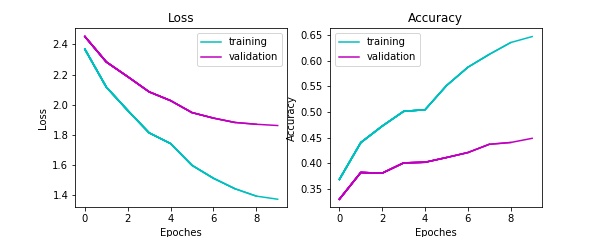

In [154]:
%matplotlib notebook
#Constants
N = 10000
d = num_px
K = len(classes)
layers = 2
m = 50
X, Y, parameters, GDparams, lambd = initialize_parameters(N, d, layers, m)
#Overriding the GDparams
GDparams = {}
GDparams['n_batch'] = 100
GDparams['eta'] = 0.1
GDparams['n_epochs'] = 10
lambd = 0.01

cyclic_params = {}
cyclic_params['eta_max'] = 1e-1
cyclic_params['eta_min'] = 1e-5
cyclic_params['eta'] = 1e-5
cyclic_params['ns'] = 500 #ns = k * lowerbound(n/nbatch)

trained_parameters = MiniBatchGD(X, Y, valid_x, valid_y, GDparams, parameters, lambd, cyclic_params)

In [155]:
H, P_test = EvaluateClassifier(test_x, trained_parameters)
print("Loss on the test dataset :",
      ComputeCost_CrossEntropy(P_test, test_y, trained_parameters))
print("Accuracy on the test datset :", ComputeAccuracy(P_test, test_y))

Loss on the test dataset : 1.838701466423084
Accuracy on the test datset : 0.4465


<IPython.core.display.Javascript object>


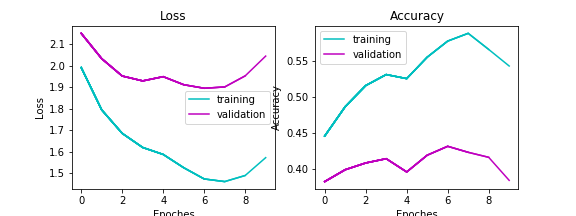

In [157]:
%matplotlib notebook
#Constants
N = 10000
d = num_px
K = len(classes)
layers = 2
m = 50
X, Y, parameters, GDparams, lambd = initialize_parameters(N, d, layers, m)
#Overriding the GDparams
GDparams = {}
GDparams['n_batch'] = 100
GDparams['eta'] = 0.1
GDparams['n_epochs'] = 10
lambd = 0.01

cyclic_params = {}
cyclic_params['eta_max'] = 1e-1
cyclic_params['eta_min'] = 1e-5
cyclic_params['eta'] = 1e-5
cyclic_params['ns'] = 500 #ns = k * lowerbound(n/nbatch)

trained_parameters = MiniBatchGD(X, Y, valid_x, valid_y, GDparams, parameters, lambd)

In [158]:
H, P_test = EvaluateClassifier(test_x, trained_parameters)
print("Loss on the test dataset :",
      ComputeCost_CrossEntropy(P_test, test_y, trained_parameters))
print("Accuracy on the test datset :", ComputeAccuracy(P_test, test_y))

Loss on the test dataset : 2.017041806357881
Accuracy on the test datset : 0.3921
